In [39]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler


#Custome graph format style sheet
plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = True
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.eps'
if not 'location' in locals():
    #save location.  First one is for running on home PC, second for running on the work laptop.  May need to make a global change
    location = 'E:\\Documents\\Dan\\Code\\FigsAndPlots\\FigsAndPlotsDocument\\Figures\\'
    #location = 'C:\\Users\\dhendrickson\\Documents\\github\\FigsAndPlots\\FigsAndPlotsDocument\\Figures\\'


#Standard cycle for collors and line styles
#default_cycler = (cycler('color', ['0.00', '0.40', '0.60', '0.70']) + cycler(linestyle=['-', '--', ':', '-.']))
#plt.rc('axes', prop_cycle=default_cycler)

In [40]:
# Task Specific includes:

#import scipy.special as sp
import math
import numba as nb
import multiprocessing
from joblib import Parallel, delayed


In [41]:
class EFIT:
    __ts = 0
    __ds = 0

    def __init__(self, xGrid, yGrid, zGrid, tStep, dStep):
        #Initialize with the size of the grid in X, Y, and Z number of nodes.  The distance step, and the time step


        #Velocity grid with 3 part vector at each node point, for 2 time steps
        self.GridShapeV = (3,xGrid,yGrid,zGrid,2)
        #Stresses with 3 part vector in each of 3 part phaces, at each nod epoint, for 2 time steps
        self.GridShapeS = (3,3,xGrid,yGrid,zGrid,2)
        #materials property gird.  Initially 3 properties needed: density, Lame 1, Lame 2
        self.GridShapeP = (3,xGrid,yGrid,zGrid)
     
        self.GridPoints = xGrid*yGrid*zGrid
        
        
        #define empty grid for the 3 directions of velocity for 2 time steps
        self.Gv = np.zeros(3*self.GridPoints*2,dtype="float32").reshape(*self.GridShapeV)
        #define empty grid for the 3 directions of stress on 3 dimmensions of faces for 2 time steps
        self.Gs = np.zeros(3*3*self.GridPoints*2,dtype="float32").reshape(*self.GridShapeS)
        #define empty grid for the 3 scalar material properties at each node point.  Can honly hold scalar properties
        #Assumed properties are density, Lame 1, Lame 2
        self.Gp = np.zeros(3*self.GridPoints,dtype="float32").reshape(*self.GridShapeP)
        
        self.__MaxX = xGrid
        self.__MaxY = yGrid
        self.__MaxZ = zGrid

        self.__ds = dStep
        self.__ts = tStep

    def CheckStressBoundary(self,x,y,z,Ds):
        #checks to see if a grid is at a boundary, and if so, adjusts boundary conditions appropriately
        #
        # Inputs: x,y,z coordinates of cube in question
        #
        # Outputs: Updated (if boundary) delta stress matrix

        #at front and back faces, stresses perpendicular to the face are 0:
        if x == 0 or x == self.__MaxX:
            Ds[0,1]=0
            Ds[0,2]=0
        
        #at top face, stresses perpendicular to the face are 0:
        if y == self.__MaxY:
            Ds[1,0]=0
            Ds[1,2]=0
        
        #at side faces, stresses perpendicular to the face are 0:
        if z == 0 or z == self.__MaxZ:
            Ds[2,1]=0
            Ds[2,0]=0
        
        return Ds

    def CheckVelocityBoundary(self,x,y,z,Dv):
        #checks to see if a grid is at a boundary, and if so, adjusts boundary conditions appropriately
        #
        # Inputs: x,y,z coordinates of cube in question
        #
        # Outputs: Updated (if boundary) delta velocity vector
        
        #lower boundary is fixed, velocity is Zero
        if y == 0:
            Dv[1]=0
            if x <= 10 or x >= self.__MaxX-10:
                Dv[0] = 0
                Dv[2] = 0

        return Dv

    
    def DeltaStress(self,x,y,z):
        #Gets the change in the stresses per time at a certain coordinate juncture 
        #
        # Inputs: x,y,z coordinates of the cube in question.  Last time is assumed
        #
        # Outputs: 6 dimmensions of stress.  
        
        #Calculated stresses based on 3.55
        Ds = np.zeros((3,3))
        
        try:
            Ds[0,0] =  ((1/self.__ds) *
                    ((self.Gp[1,x,y,z]+2*self.Gp[2,x,y,z])*(self.Gv[0,x,y,z,1]-self.Gv[0,x-1,y,z,1]) +
                        self.Gp[1,x,y,z]*(self.Gv[1,x,y,z,1]-self.Gv[1,x,y-1,z,1]+self.Gv[2,x,y,z,1]-self.Gv[2,x,y,z-1,1])
                        )
                    )
        except:
            Ds[0,0]=0
        
        try:
            Ds[1,1] =  ((1/self.__ds) *
                    ((self.Gp[1,x,y,z]+2*self.Gp[2,x,y,z])*(self.Gv[1,x,y,z,1]-self.Gv[1,x,y-1,z,1]) +
                        self.Gp[1,x,y,z]*(self.Gv[0,x,y,z,1]-self.Gv[0,x-1,y,z,1]+self.Gv[2,x,y,z,1]-self.Gv[2,x,y,z-1,1])
                        )
                    )
        except:
            Ds[1,1]=0
        
        try:
            Ds[2,2] =  ((1/self.__ds) *
                    ((self.Gp[1,x,y,z]+2*self.Gp[2,x,y,z])*(self.Gv[2,x,y,z,1]-self.Gv[2,x,y,z-1,1]) +
                        self.Gp[1,x,y,z]*(self.Gv[0,x,y,z,1]-self.Gv[0,x-1,y,z,1]+self.Gv[1,x,y,z,1]-self.Gv[1,x,y-1,z,1])
                        )
                    )
        except:
            Ds[2,2]=0
        
        try:
            Ds[0,1] =  (
                    (1/self.__ds) *
                    (4/((1/self.Gp[2,x,y,z])+(1/self.Gp[2,x+1,y,z])+(1/self.Gp[2,x,y+1,z])+(1/self.Gp[2,x+1,y+1,z]))) *
                    (self.Gv[0,x,y+1,z,1]-self.Gv[0,x,y,z,1] +self.Gv[1,x+1,y,z,1]-self.Gv[1,x,y,z,1] )
                    )
        except:
            Ds[0,1]=0
        
        try:
            Ds[0,2] =  (
                    (1/self.__ds) *
                    (4/((1/self.Gp[2,x,y,z])+(1/self.Gp[2,x+1,y,z])+(1/self.Gp[2,x,y,z+1])+(1/self.Gp[2,x+1,y,z+1]))) *
                    (self.Gv[0,x,y,z+1,1]-self.Gv[0,x,y,z,1] +self.Gv[2,x+1,y,z,1]-self.Gv[2,x,y,z,1] )
                    )
        except:
            Ds[0,2]=0
        
        try:
            Ds[1,2] =  (
                    (1/self.__ds) *
                    (4/((1/self.Gp[2,x,y,z])+(1/self.Gp[2,x,y+1,z])+(1/self.Gp[2,x,y,z+1])+(1/self.Gp[2,x,y+1,z+1]))) *
                    (self.Gv[1,x,y,z+1,1]-self.Gv[1,x,y,z,1] +self.Gv[2,x,y+1,z,1]-self.Gv[2,x,y,z,1] )
                    )
        except:
            Ds[1,2]=0
        

        Ds = self.CheckStressBoundary(x,y,z,Ds)

        return Ds

    def DeltaVelocity(self, x,y,z):
        #Gets the change in the velocity per time at a certain coordinate juncture 
        #
        # Inputs: x,y,z coordinates of the cube in question.  Last time is assumed
        #
        # Outputs: 3 dimmensions of velocity.  
        
        #Calculated velocity based on 3.54

        DV = np.zeros(3)

        try:
            DV[0] = ((1 / self.__ds ) *
                              (2 / (self.Gp[0,x,y,z]+self.Gp[0,x+1,y,z])) *
                              (self.Gs[0,0,x+1,y,z,1] - self.Gs[0,0,x,y,z,1] + self.Gs[0,1,x,y,z,1] - self.Gs[0,1,x,y-1,z,1] + self.Gs[0,2,x,y,z,1] -self.Gs[0,2,x,y,z-1,1])
                              )
        except:
            DV[0]=0
        
        #calculate velocity in y based on 3.54
        try:
            DV[1] = ((1 / self.__ds ) *
                              (2 / (self.Gp[0,x,y,z]+self.Gp[0,x,y+1,z])) *
                              (self.Gs[0,1,x,y,z,1] - self.Gs[0,1,x-1,y,z,1] + self.Gs[1,1,x,y+1,z,1] - self.Gs[1,1,x,y,z,1] + self.Gs[1,2,x,y,z,1] -self.Gs[1,2,x,y,z-1,1])
                              )
        except:
            DV[1]=0

        #calculate velocity in z based on 3.54
        try:
            DV[2] = ((1 / self.__ds ) *
                              (2 / (self.Gp[0,x,y,z]+self.Gp[0,x,y,z+1])) *
                              (self.Gs[0,2,x,y,z,1] - self.Gs[0,2,x-1,y,z,1] + self.Gs[1,2,x,y,z,1] - self.Gs[1,2,x,y-1,z,1] + self.Gs[2,2,x,y,z+1,1] -self.Gs[2,2,x,y,z,1])
                              )
        except:
            DV[2]=0
        
        DV = self.CheckVelocityBoundary(x,y,z,DV)

        return DV
    
    #@nb.jit(nopython=True, parallel=True)
    def UpdateStresses(self, triple):
        #Updates velocity based off of previous velocities and delta velocity times time
        #
        # Inputs: Coordinates of cube in question.  Assumed last time step
        #
        # Output: updated self.Gs matrix
        
        x = triple[0]
        y = triple[1]
        z = triple[2]
        
        self.Gs[:,:,x,y,z,0] = self.Gs[:,:,x,y,z,1]
        
        delS = self.DeltaStress(x,y,z)

        for i in range(3):
                for j in range(3):
                    self.Gs[i,j,x,y,z,1] += delS[i,j] * self.__ts

        return self

    def UpdateStressesSeries(self, x,y,z):
        #Updates velocity based off of previous velocities and delta velocity times time
        #
        # Inputs: Coordinates of cube in question.  Assumed last time step
        #
        # Output: updated self.Gs matrix
        
        self.Gs[:,:,x,y,z,0] = self.Gs[:,:,x,y,z,1]
        
        delS = self.DeltaStress(x,y,z)

        for i in range(3):
                for j in range(3):
                    self.Gs[i,j,x,y,z,1] += delS[i,j] * self.__ts

        return self

    #@nb.jit(nopython=True, parallel=True)
    def UpdateVelocity(self,triple):
        #Updates velocity based off of previous velocities and delta velocity times time
        #
        # Inputs: Coordinates of cube in question.  Assumed last time step
        #
        # Output: updated self.Gs matrix

        x = triple[0]
        y = triple[1]
        z = triple[2]

        self.Gv[:,x,y,z,0] = self.Gv[:,x,y,z,1]
        
        delV = self.DeltaVelocity(x,y,z)

        for i in range(3):
            self.Gv[i,x,y,z,1] += delV[i] * self.__ts

        return self
    
    def UpdateVelocitySeries(self,x,y,z):
        #Updates velocity based off of previous velocities and delta velocity times time
        #
        # Inputs: Coordinates of cube in question.  Assumed last time step
        #
        # Output: updated self.Gs matrix

        self.Gv[:,x,y,z,0] = self.Gv[:,x,y,z,1]
        
        delV = self.DeltaVelocity(x,y,z)

        for i in range(3):
            self.Gv[i,x,y,z,1] += delV[i] * self.__ts

        return self
    
    def ForcingFunctionWave(self, t):
        # Adds stresses from a force to the stress grid
        # Initially assumed a single force of a small plate sinosoidal ultrasound emitter.  More to be added later
        # 
        # Input is the time
        #
        # Outputs: no direct outputs, last time step stress is updated

        frequency = 200000
        EmitterPreasure = 100
        
        ##run for two periods and then stop:
        #if 2.0 / frequency < t:
            
        EmitterWidth = 0.01 / self.__ds

        EmitterWidth = int(EmitterWidth)

        #emitter placed in middle of top face
        
        StartX = int(self.__MaxX / 2 - EmitterWidth / 2)
        StartZ = int(self.__MaxZ / 2 - EmitterWidth / 2)

        for i in range(EmitterWidth):
            for j in range(EmitterWidth):
                self.Gs[1,1,i+StartX,self.__MaxY-2,j+StartZ,1] = np.sin(frequency * t) * EmitterPreasure

        return self

    def ForcingFunctionImpulse(self, force = 10, emitter = 0.01):
        # Adds stresses from a force to the stress grid
        # Initially assumed a single force of a small plate sinosoidal ultrasound emitter.  More to be added later
        # 
        # Input is the time
        #
        # Outputs: no direct outputs, last time step stress is updated

        EmitterWidth = emitter / self.__ds

        EmitterWidth = int(EmitterWidth)

        #emitter placed in middle of top face
        
        StartX = int(self.__MaxX / 2 - EmitterWidth / 2)
        StartZ = int(self.__MaxZ / 2 - EmitterWidth / 2)

        #for i in range(EmitterWidth):
        #    for j in range(EmitterWidth):
        self.Gs[1,1,StartX:StartX+EmitterWidth,self.__MaxY-1,StartZ:StartZ+EmitterWidth,1] = force

        return self

    def VelocityCut(self, Dimm, location = -1):
        #Gets a cut of the magnitude of velocity in a plane defined by the two dimmension, cut at the location given in location
        #
        # Inputs: Dimm is the dimmension that is orthoganl to the plane that will be reutrned.
        #         Location if given will be the cut allong the thrid dimmension that will be returned.  
        #               If not given, -1 is default, it will signal using the centroid by default
        #
        # Outputs: 2 dimesional matrix with the combined velocity in the 2 given dimensions

        Results = []

        if Dimm == 0:
            if location > self.__MaxX or location < 0: location = -1
            if location == -1:
                location = int(self.__MaxX / 2)
            Component1 = np.matrix((self.__MaxY, self.__MaxZ))
            Component2 = np.matrix((self.__MaxY, self.__MaxZ))

            Component1 = self.Gv[1,location,:,:,1]
            Component2 = self.Gv[2,location,:,:,1]
            
            Results = Component1 + Component2
            #Results = np.sqrt(np.add(np.multiply(Component1,Component1),np.multiply(Component2,Component2)))

        if Dimm == 1:
            if location > self.__MaxY or location < 0: location = -1
            if location == -1:
                location = int(self.__MaxY / 2)
            Component1 = np.matrix((self.__MaxX, self.__MaxZ))
            Component2 = np.matrix((self.__MaxX, self.__MaxZ))

            Component1 = self.Gv[0,:,location,:,1]
            Component2 = self.Gv[2,:,location,:,1]
            
            Results = Component1 + Component2
            # Results = np.sqrt(np.add(np.multiply(Component1,Component1),np.multiply(Component2,Component2)))
            
        if Dimm == 2:
            if location > self.__MaxZ or location < 0: location = -1
            if location == -1:
                location = int(self.__MaxZ / 2)
            Component1 = np.matrix((self.__MaxX, self.__MaxY))
            Component2 = np.matrix((self.__MaxX, self.__MaxY))

            Component1 = self.Gv[0,:,:,location,1]
            Component2 = self.Gv[1,:,:,location,1]
            
            Results = Component1 + Component2
            #Results = np.sqrt(np.add(np.multiply(Component1,Component1),np.multiply(Component2,Component2)))
            

        return Results


In [42]:
def PlotSlice(data, title='', colormap='grey'):
    
    x = np.linspace(1,np.shape(data)[0],np.shape(data)[0])
    y = np.linspace(1,np.shape(data)[1],np.shape(data)[1])
    X,Y  = np.meshgrid(y,x)

    fig1 = plt.figure(figsize=(6.67,3.75))
    ax1 = plt.axes()
    cs1 = ax1.contourf(X,Y, data,cmap=colormap,levels=10)

    if Titles: plt.title(title)
    if Saving: plt.savefig(location+title.replace(" ", "").replace(":", "").replace(",", "").replace(".txt","")+FFormat)

    plt.show()

In [43]:
def animation(data,i):
    
    x = np.linspace(1,np.shape(data[i][0])[0],np.shape(data[0][0])[0])
    y = np.linspace(1,np.shape(data[i][0])[1],np.shape(data[0][0])[1])
    X,Y  = np.meshgrid(x,y)

    fig1 = plt.figure(figsize=(6.67,3.75))
    ax1 = plt.axes()
    
    cs1 = ax1.contourf(X,Y, np.matrix(data[i][0]),cmap='RdYlBu',levels=10)

    plt.show()

    pass

In [44]:
# set Constants:
PoissonRatio = 0.3
YoungModulus = 20 * (10**9)
mu = 80 * (10**9)         #First Lame Parameter
lmbda = 2 * mu * PoissonRatio / (1 - 2 * PoissonRatio)     #second Lame Parameter
rho = 7800       #density

#Calculate speed of longitudinal and transverse waves
cl = np.sqrt((lmbda + 2* mu)/rho)
ct = np.sqrt(mu/rho)

print(cl,ct)

#Choose ferquency to be used for excitment
frequency = 200000

#calculate wave length
omegal = cl / frequency
omegat = ct / frequency

print(omegal,omegat)

# about 1foot (0.3m) of just the web of 175lbs rail 
BeamLength = 0.3
BeamHeight = 0.0762
BeamWidth = 0.0381

5991.446895152781 3202.563076101743
0.029957234475763903 0.016012815380508715


Rail Properties:
https://railroadrails.com/railroad-rail-specification/
Using 175LBS Rail baseline

Steel Propoerties:
https://www.jsg.utexas.edu/tyzhu/files/Some-Useful-Numbers.pdf

relation between properties na dparameters:
https://en.wikipedia.org/wiki/Lam%C3%A9_parameters


In [45]:
#Run for 2 Cycles:
runtime = 6.0 / frequency 


#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
ts = 1 / frequency / 20    #time step
gs = min(omegal, omegat) / 10    #grid step

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time STeps

gl = int(math.ceil(BeamLength / gs)) *2        #number of grid points
gh = int(math.ceil(BeamHeight / gs)) *2
gw = int(math.ceil(BeamWidth / gs)) *2

print(gl,gh,gw, ts, gs)

376 96 48 2.5000000000000004e-07 0.0016012815380508714


In [46]:
#Initialize EFIT Model
Rail = EFIT(gl, gh, gw, ts, gs)

#Set Material Properties consitant througout
Rail.Gp[0,:,:,:] = rho  #constant Density
Rail.Gp[1,:,:,:] = lmbda #Constant first Lamee parameter 
Rail.Gp[2,:,:,:] = mu  #constant second Lamee parameter

num_cores = multiprocessing.cpu_count()

IEEE ultrasonics
SBIE NDE section NDE and smart structures
quantitiative

In [47]:
# Initiallize Time step 1:

#Rail.Gv[:,:,:,:,:] = 0
#Rail.Gs[:,:,:,:,:,:] = 0



In [58]:
#Run main function for time:
CenterXResults = []
CenterYResults = []
CenterZResults = []

x = np.linspace(0, BeamLength, gl)
y = np.linspace(0, BeamHeight, gh)
X,Y = np.meshgrid(x,y)

plt.ion()

fig = plt.figure()
ax = plt.axes(xlim=(0, BeamLength), ylim=(0, BeamWidth))  
plt.xlabel(r'length')
plt.ylabel(r'height')

#AllCombos = np.array(np.meshgrid(range(gl),range(gh),range(gw))).T.reshape(-1,3)
#GroupSize = num_cores*3
#Groups = math.ceil(np.shape(AllCombos)[0] / GroupSize)

for i in range(Tsteps - 1):
    t = (i+1) * ts

    #Update Stresses at next half step:
    for x in range(gl):
        for y in range(gh):
            for z in range(gw):
                Rail.UpdateStressesSeries(x,y,z)
    #for j in range(Groups):
    #    null = Parallel(n_jobs=num_cores)(delayed(Rail.UpdateStresses)(triple) for triple in AllCombos[j*GroupSize:(j+1)*GroupSize])

    #Update stresses with forcing function
    #if t <= 2.0 / frequency: Rail.ForcingFunctionWave(t)
    if i >= 3 and i <= 33: Rail.ForcingFunctionWave(t)

    #update Velocity:
    for x in range(gl):
        for y in range(gh):
            for z in range(gw):
                Rail.UpdateVelocitySeries(x,y,z)
    #for j in range(Groups):
    #    null = Parallel(n_jobs=num_cores)(delayed(Rail.UpdateVelocity)(triple) for triple in AllCombos[j*GroupSize:(j+1)*GroupSize])
    
    j = 0
    
    # Store results mid process for latter animating
    if i % 2 == 0:
        print(str(i+1) + ' of ' + str(Tsteps-1) +' time steps. time is: '+ str(t))
        #data = Rail.VelocityCut(0)
        CenterXResults.append((Rail.VelocityCut(0),t))
        CenterYResults.append((Rail.VelocityCut(1),t))
        CenterZResults.append((Rail.VelocityCut(2),t))

        # animation function
        z = np.matrix(CenterZResults[j][0][:,:]).T
        cont = plt.contourf(X, Y, z, levels=25, cmap='RdYlBu')
        plt.fig.canvas.draw()
        j+=1

    
    

In [56]:
j


0

In [ ]:
import matplotlib.animation as animation
from IPython import display
import time

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


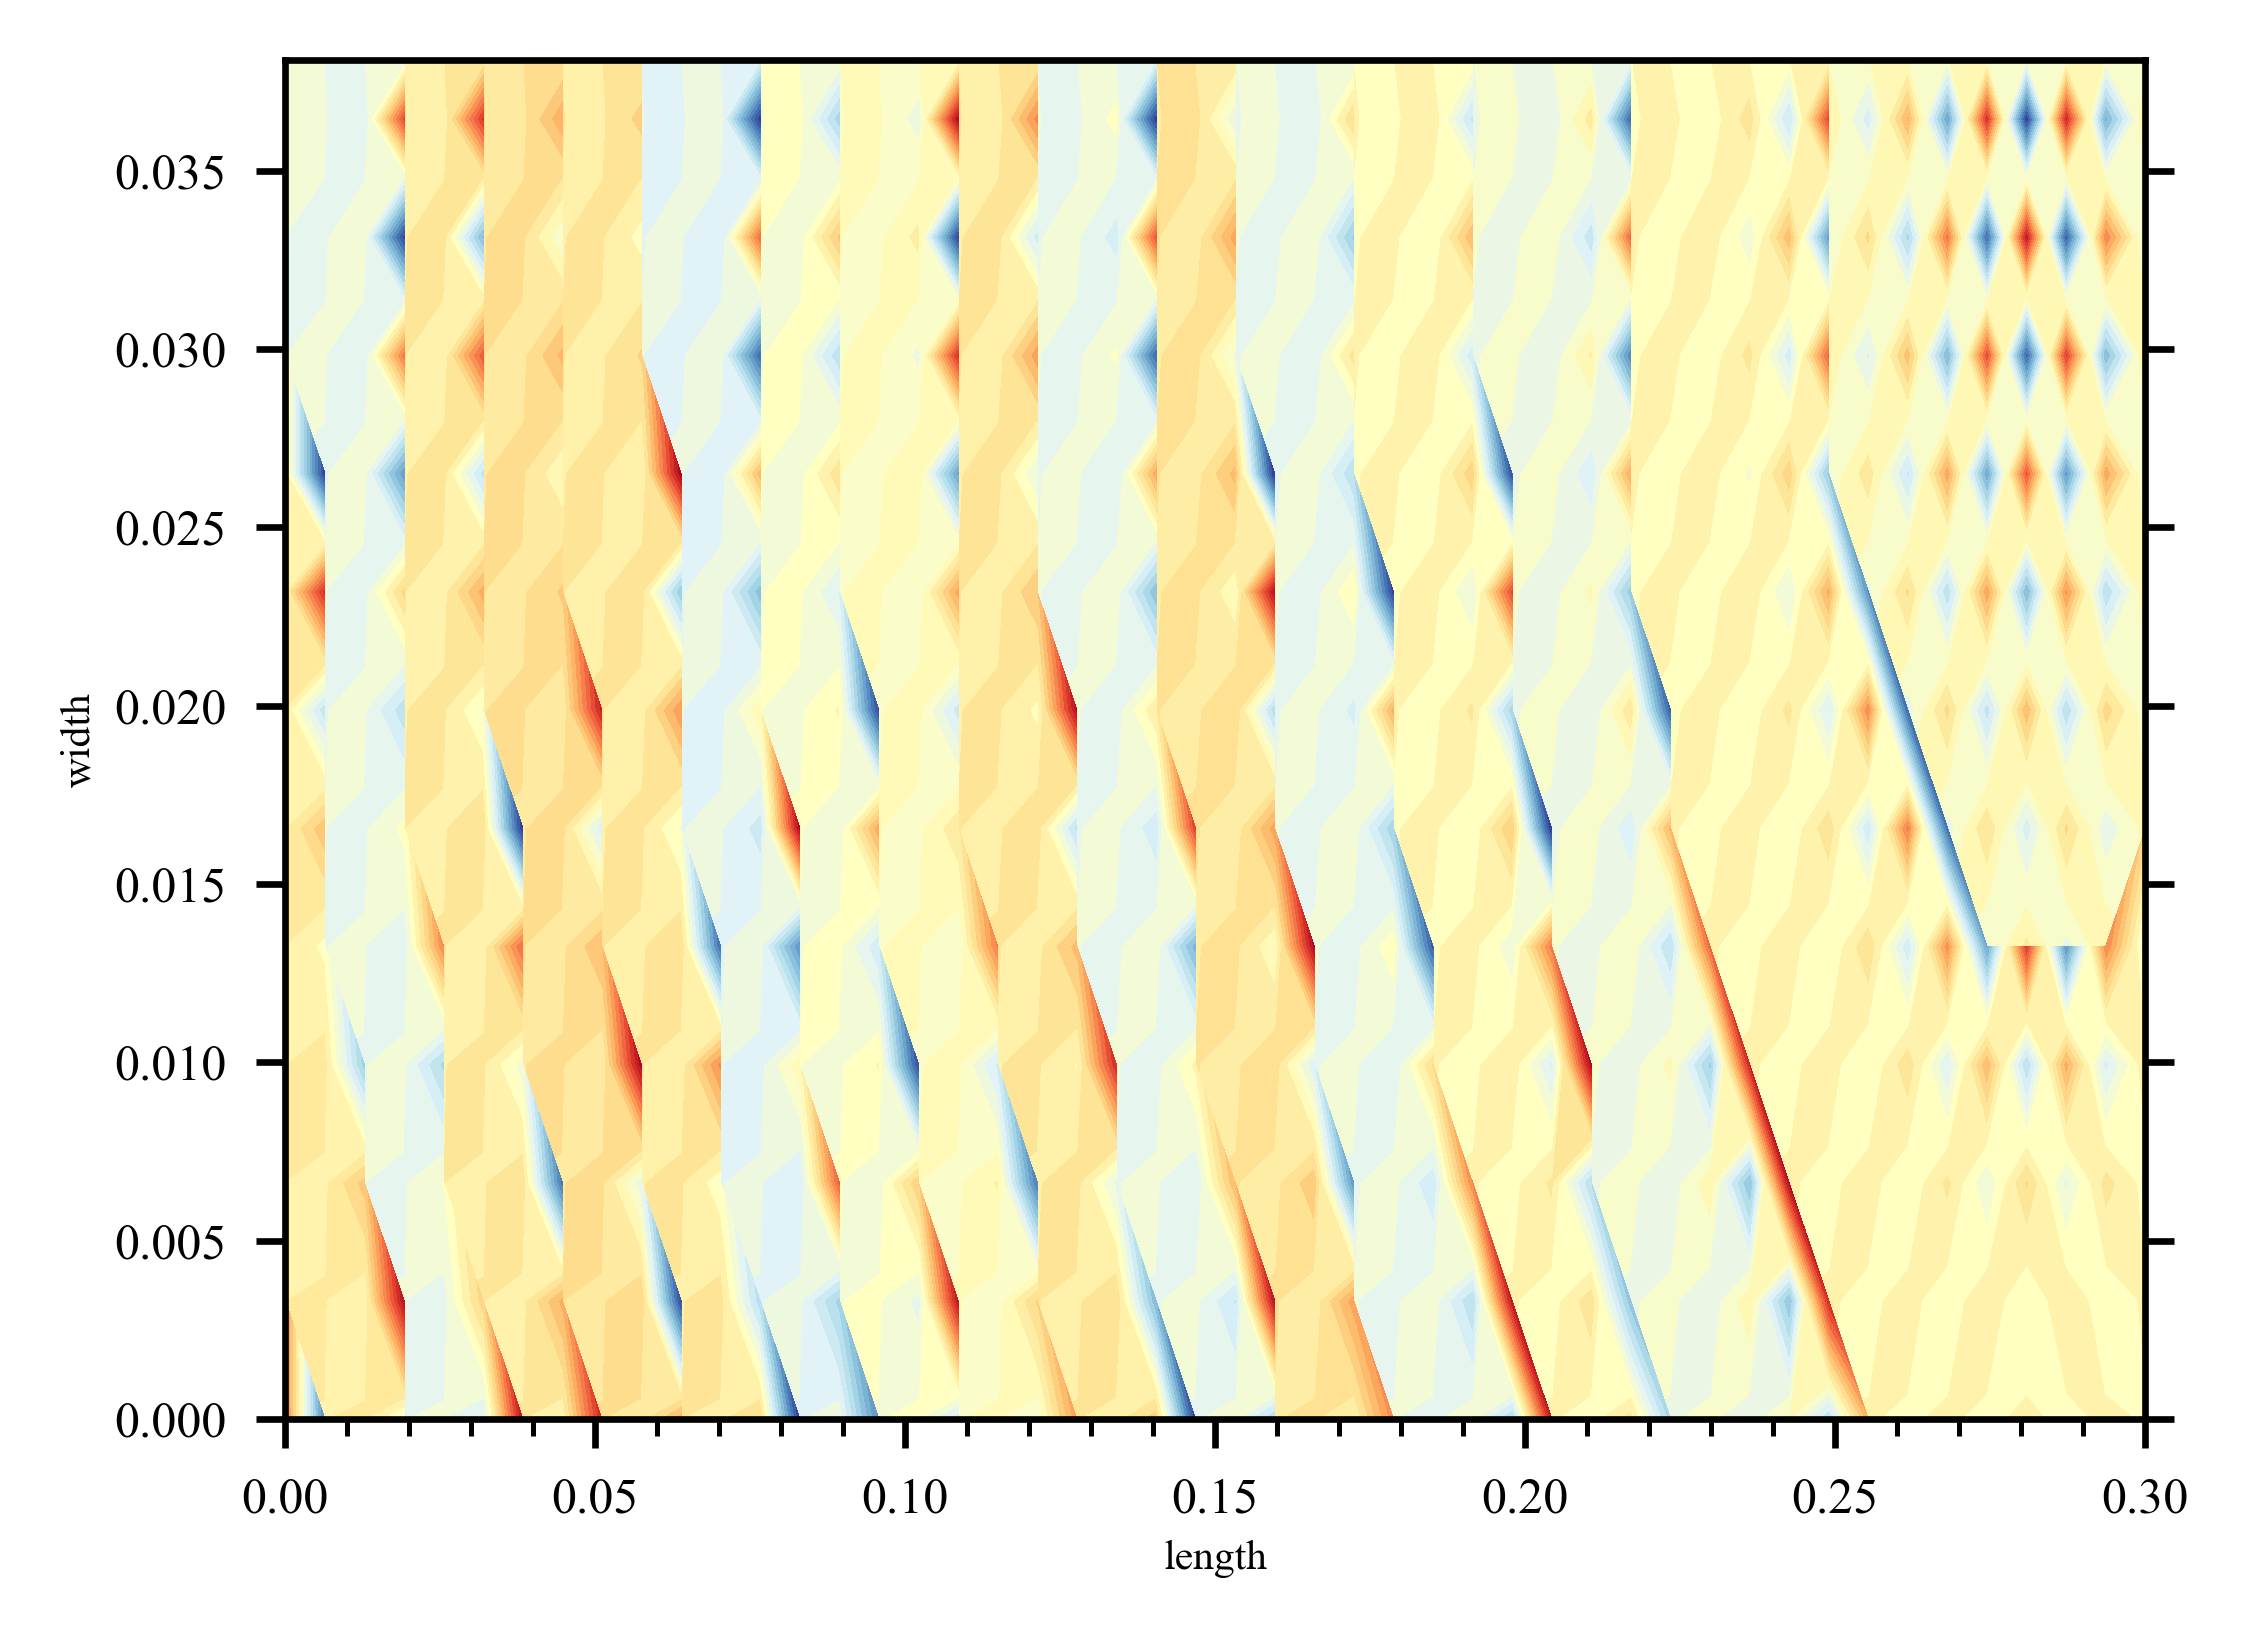

In [ ]:
x = np.linspace(0, BeamLength, np.shape(CenterXResults[0][0])[0])
y = np.linspace(0, BeamHeight, np.shape(CenterXResults[0][0])[1])
x,y = np.meshgrid(x,y)

fig = plt.figure()
ax = plt.axes(xlim=(0, BeamLength), ylim=(0, BeamWidth))  
plt.xlabel(r'length')
plt.ylabel(r'width')

# animation function
def animate(i): 
    z = np.matrix(CenterXResults[i][0][:,:]).T
    cont = plt.contourf(x, y, z, levels=25, cmap='RdYlBu')
    time.sleep(1)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=np.shape(CenterXResults)[0])

anim.save('animationX.mp4')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


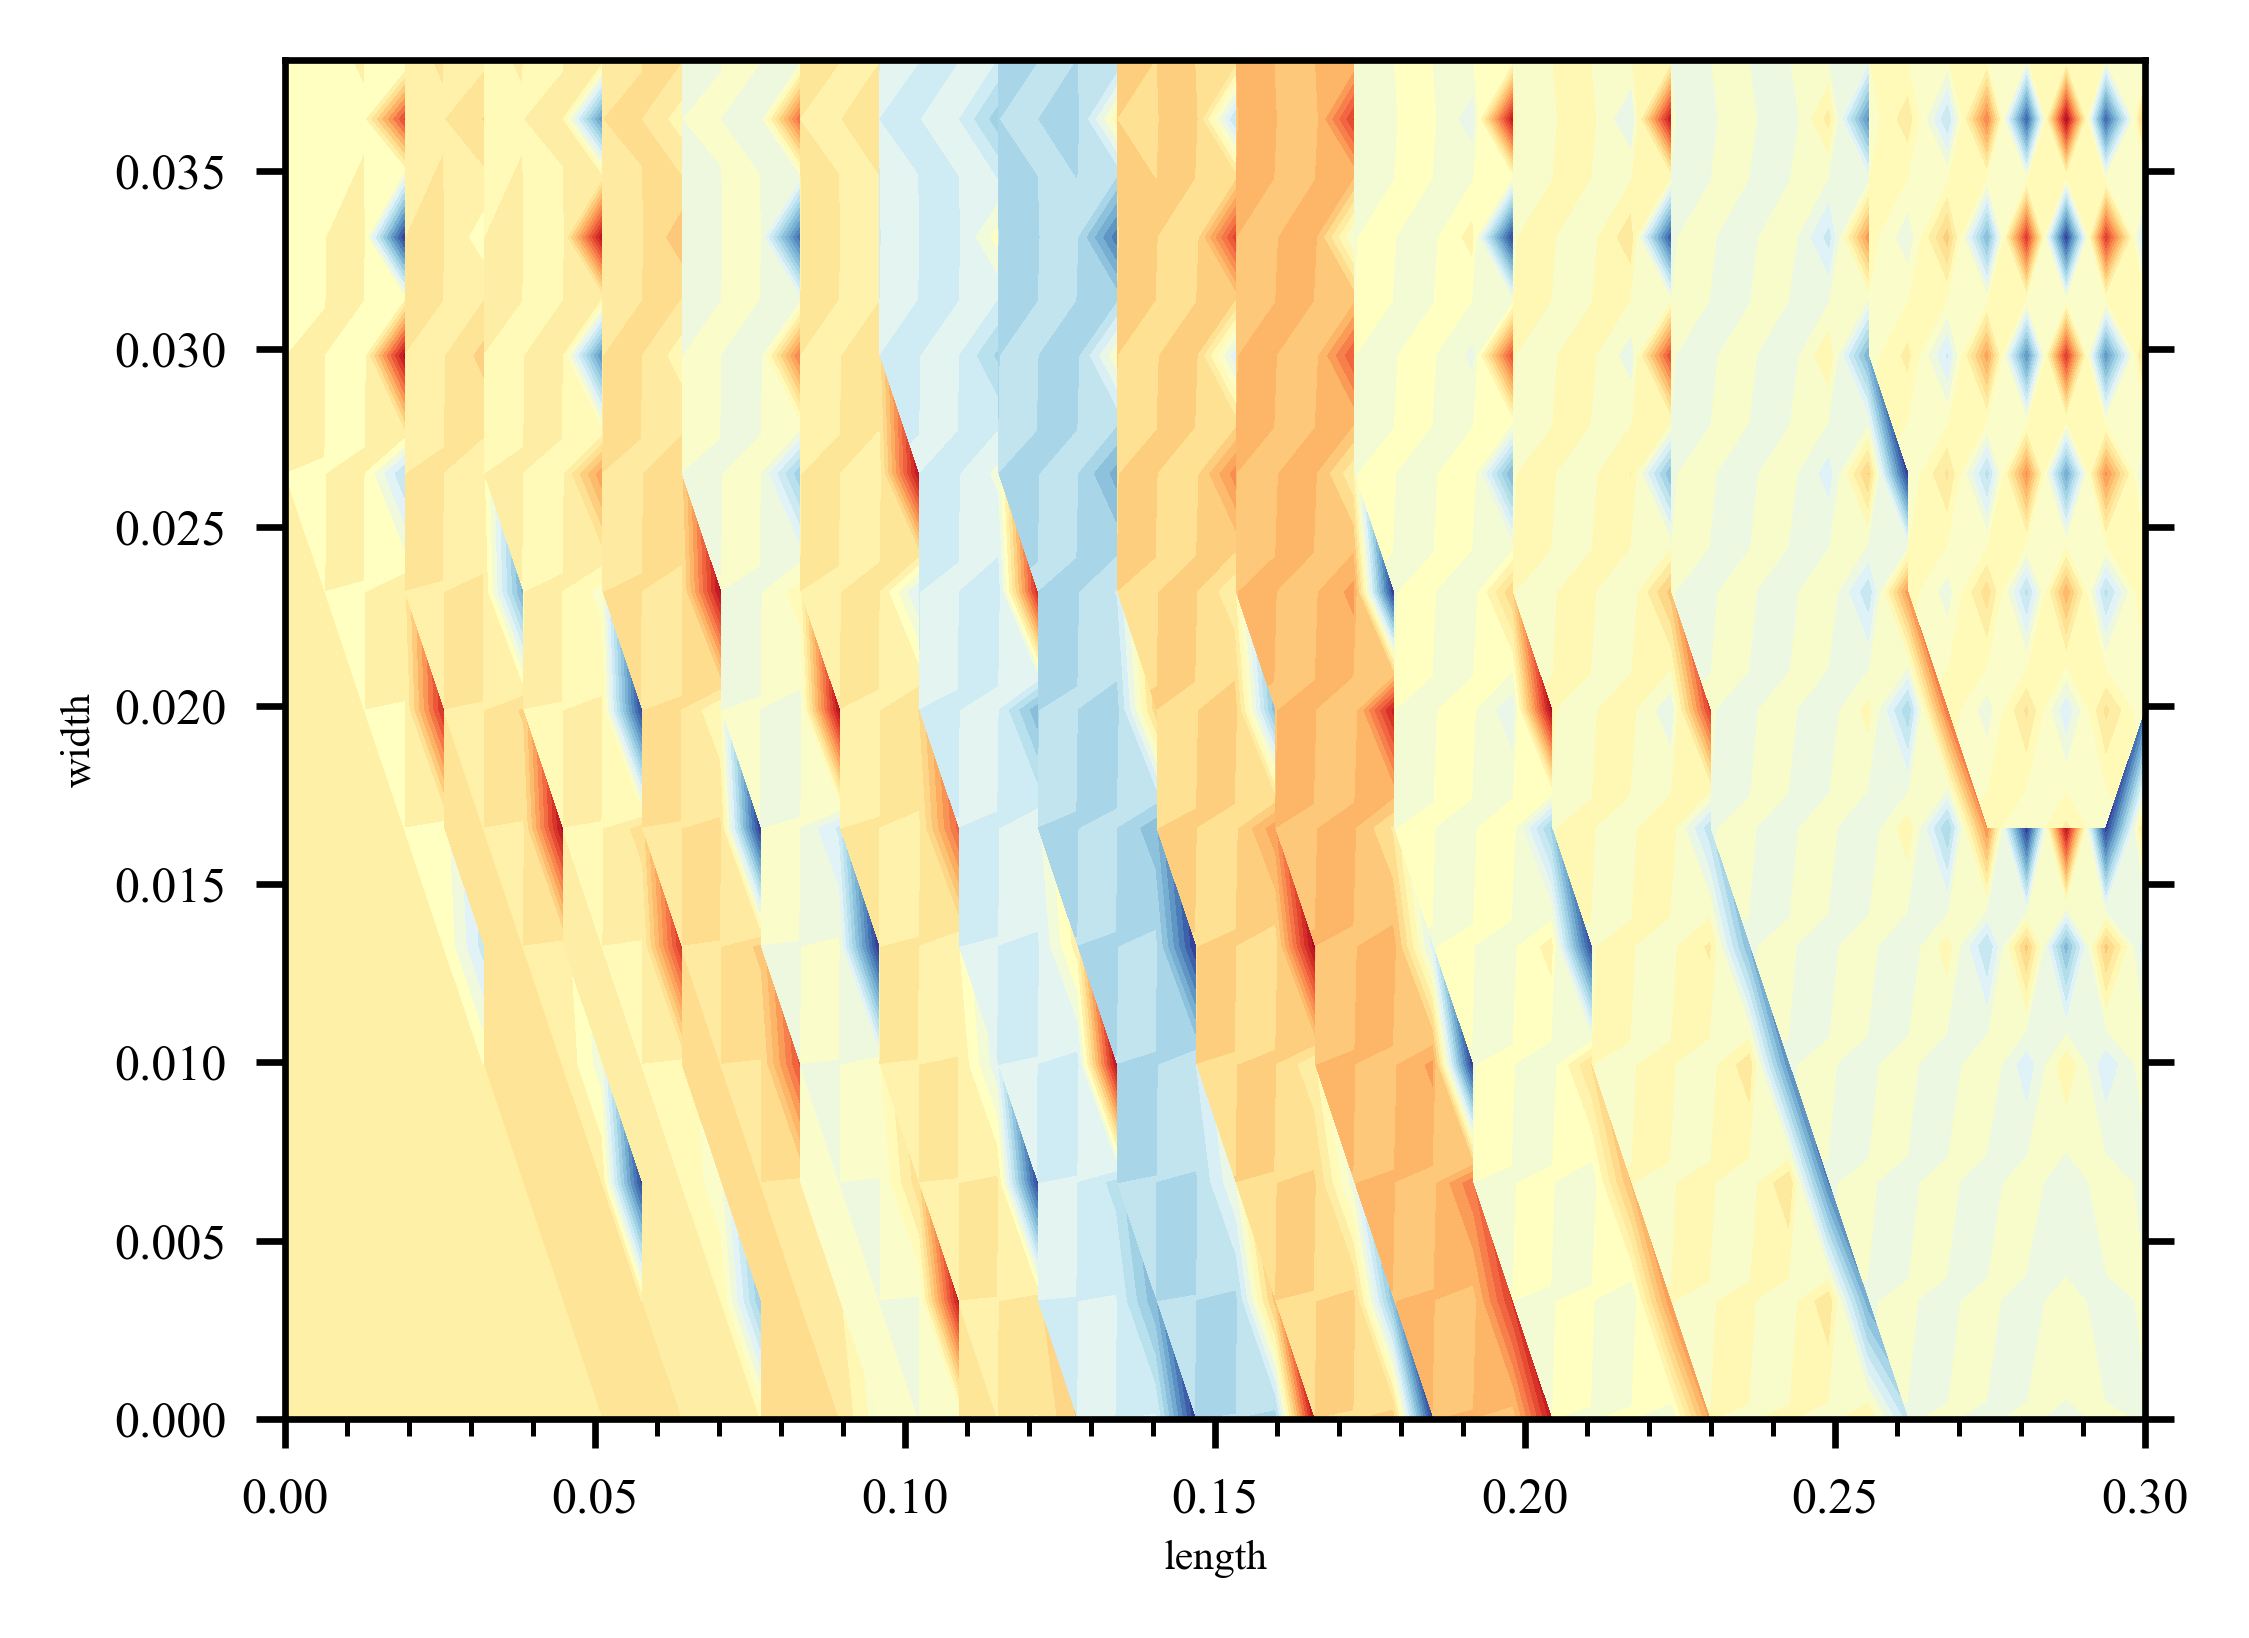

In [ ]:
x = np.linspace(0, BeamLength, np.shape(CenterYResults[0][0])[0])
y = np.linspace(0, BeamHeight, np.shape(CenterYResults[0][0])[1])
x,y = np.meshgrid(x,y)

fig = plt.figure()
ax = plt.axes(xlim=(0, BeamLength), ylim=(0, BeamWidth))  
plt.xlabel(r'length')
plt.ylabel(r'width')

# animation function
def animate(i): 
    z = np.matrix(CenterYResults[i][0][:,:]).T
    cont = plt.contourf(x, y, z, levels=25, cmap='RdYlBu')
    time.sleep(1)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=np.shape(CenterYResults)[0])

anim.save('animationY.mp4')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


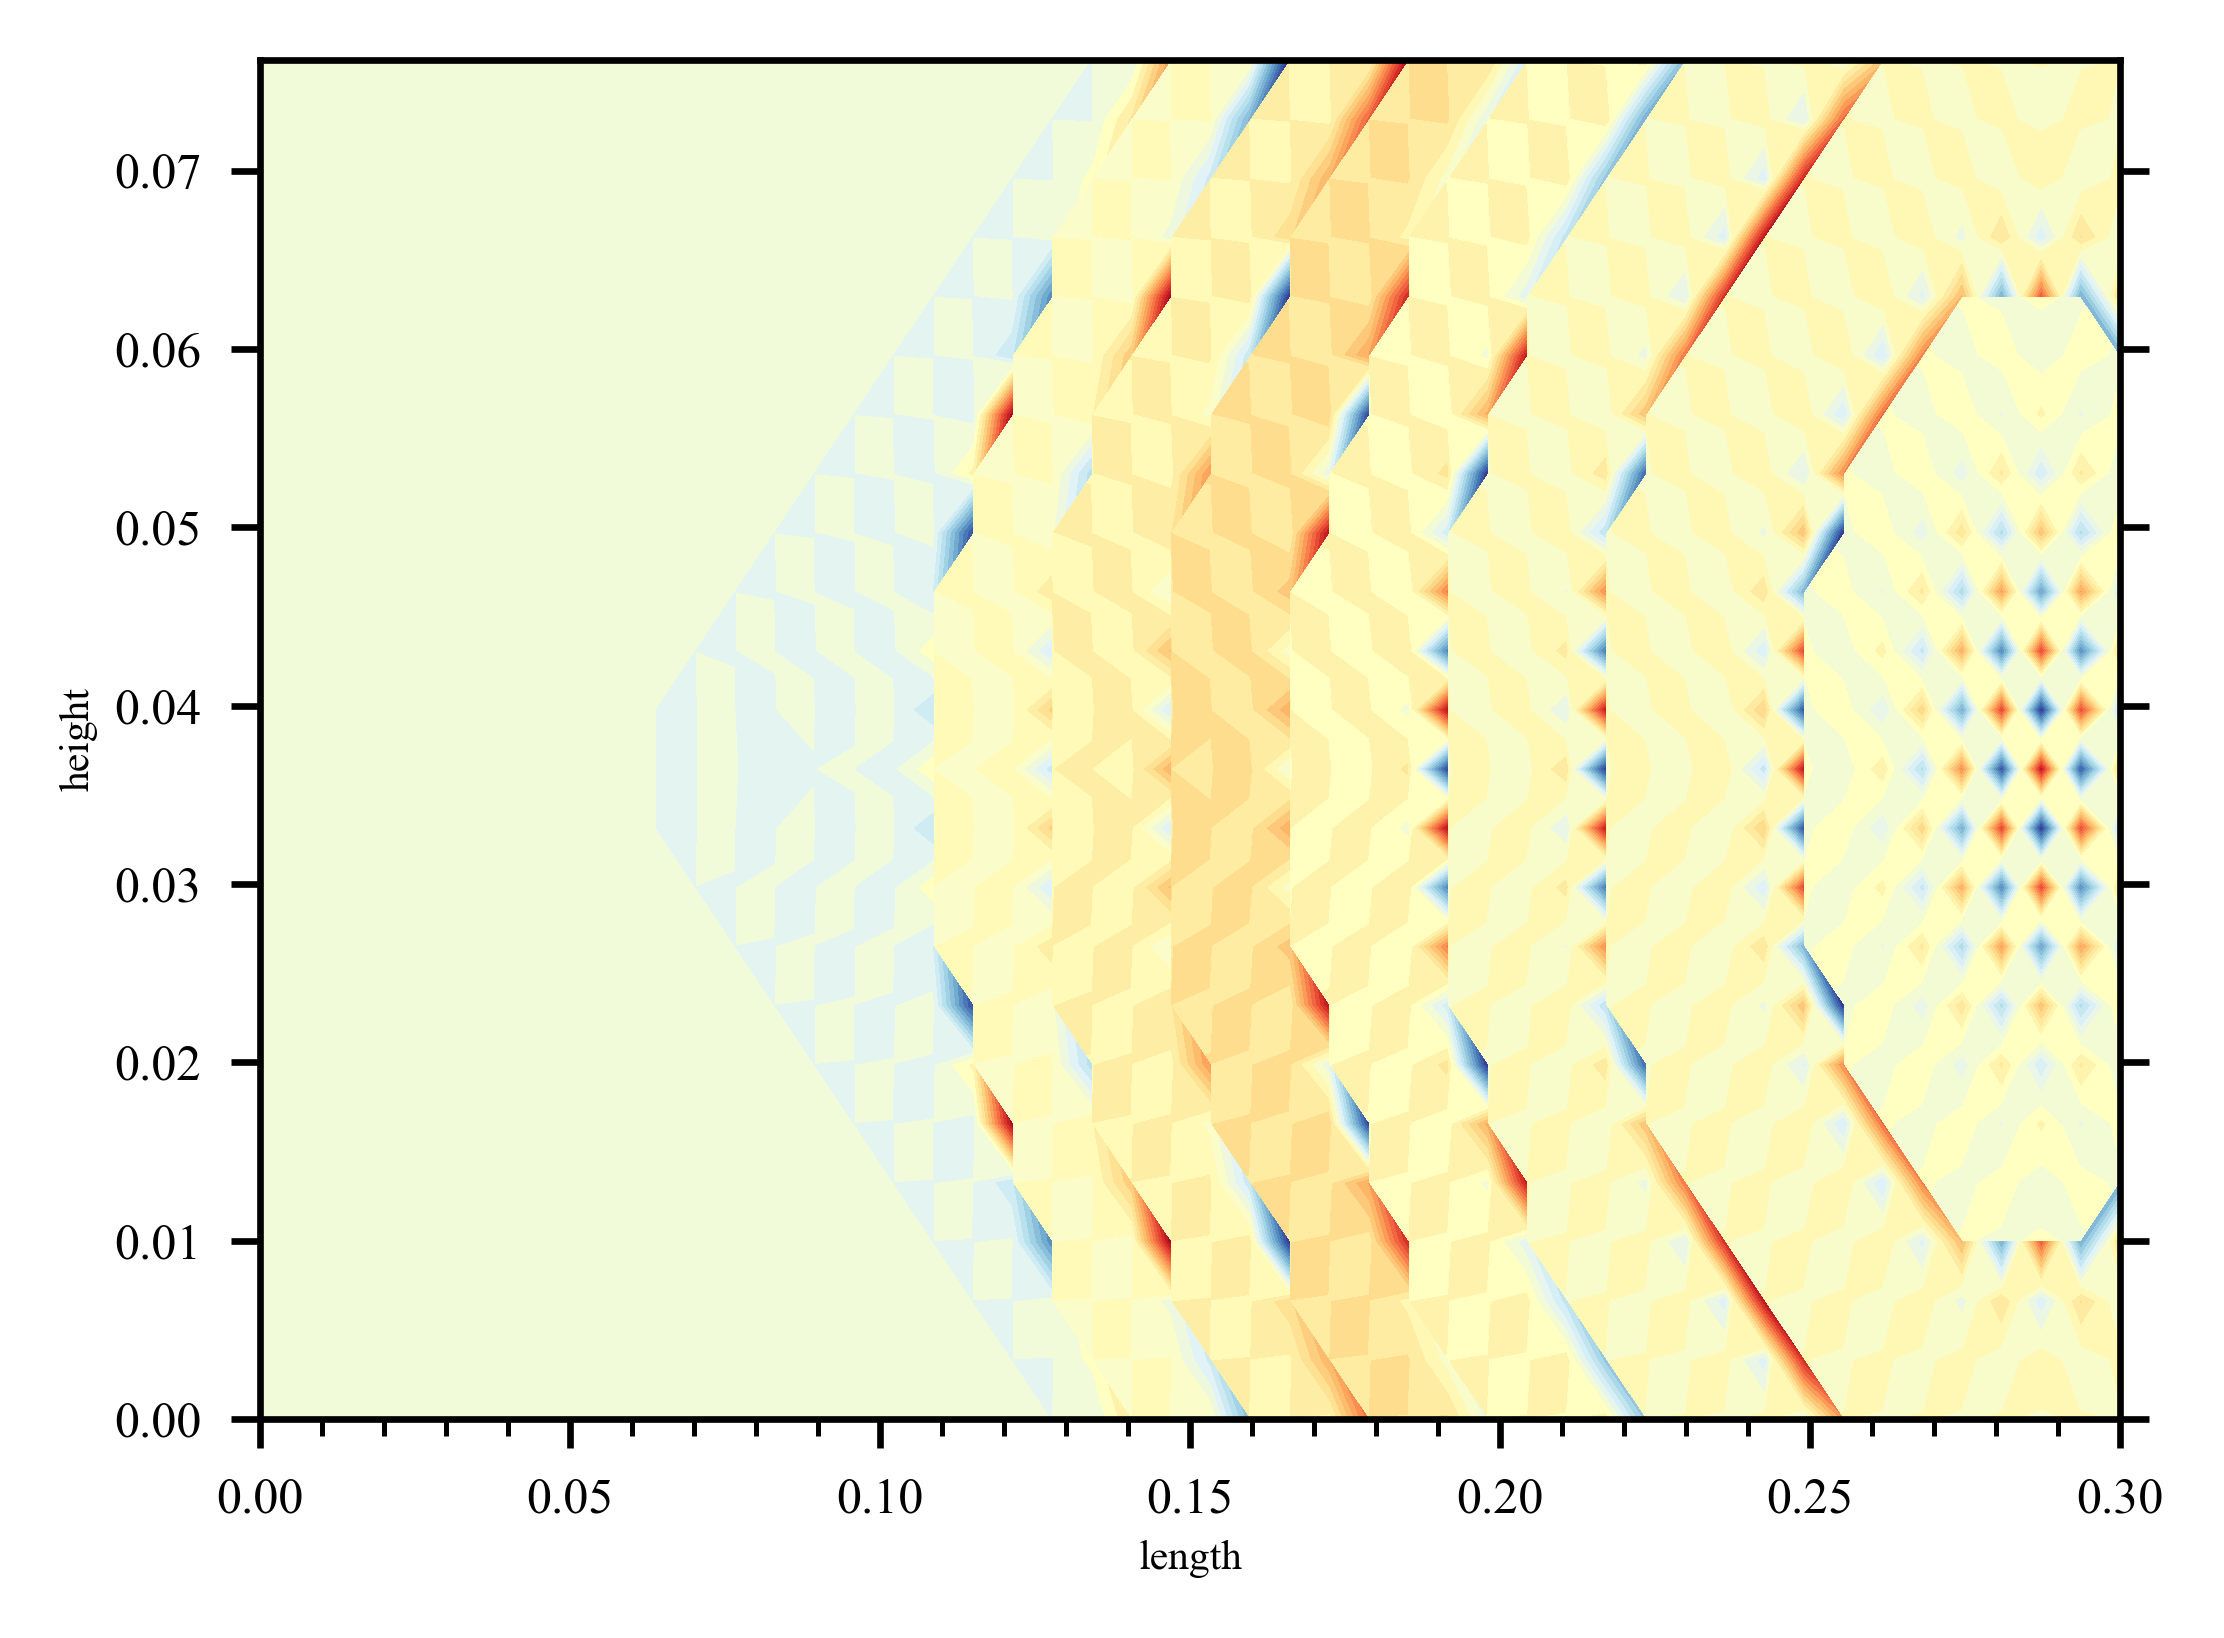

In [ ]:
x = np.linspace(0, BeamLength, np.shape(CenterZResults[0][0])[0])
y = np.linspace(0, BeamHeight, np.shape(CenterZResults[0][0])[1])
x,y = np.meshgrid(x,y)

fig = plt.figure()
ax = plt.axes(xlim=(0, BeamLength), ylim=(0, BeamHeight))  
plt.xlabel(r'length')
plt.ylabel(r'height')

# animation function
def animate(i): 
    z = np.matrix(CenterZResults[i][0][:,:]).T
    cont = plt.contourf(x, y, z, levels=25, cmap='RdYlBu')
    time.sleep(1)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=np.shape(CenterZResults)[0])

anim.save('animationZ.mp4')